In [5]:
import pandas as pd
import numpy as np
import os

ZENODO_DIR = "../Data/Zenodo/gridded_datasets"  

ab = pd.read_csv(os.path.join(ZENODO_DIR, "gridded_abundances.csv"))
pic = pd.read_csv(os.path.join(ZENODO_DIR, "gridded_pic.csv"))
poc = pd.read_csv(os.path.join(ZENODO_DIR, "gridded_poc.csv"))

# --- Normalize abundance column names to match pic/poc keys ---
ab = ab.rename(columns={
    "Latitude": "lat",
    "Longitude": "lon",
    "Depth": "depth",
    "Month": "month",
    "Year": "year",
    "Species": "species",
    "cells L-1": "cells_per_L"
})

# pic/poc already use lat/lon/depth/month/year/species in your description
# Ensure those exact key names exist:
pic = pic.rename(columns={"Latitude": "lat", "Longitude": "lon", "Depth": "depth",
                          "Month": "month", "Year": "year", "Species": "species"})
poc = poc.rename(columns={"Latitude": "lat", "Longitude": "lon", "Depth": "depth",
                          "Month": "month", "Year": "year", "Species": "species"})

# If pic/poc use different casing (common), this makes it consistent:
for df in [pic, poc]:
    # if already correct, this does nothing
    df.columns = [c.strip() for c in df.columns]

# --- Rename PIC/POC med + keep all CI columns automatically ---
def rename_med_and_keep_ci(df, prefix):
    # Find med column (common names: 'med', 'Med', 'median', etc.)
    med_col = None
    for c in df.columns:
        if c.lower() == "med":
            med_col = c
            break
    if med_col is None:
        raise ValueError(f"Could not find 'med' column in {prefix} file. Columns: {df.columns.tolist()}")

    # Identify CI columns that start with CI_95_ (case-insensitive)
    ci_cols = [c for c in df.columns if c.upper().startswith("CI_95_")]

    # Keep keys + med + CI columns
    keys = ["lat", "lon", "depth", "month", "year", "species"]
    keep = keys + [med_col] + ci_cols
    out = df[keep].copy()

    out = out.rename(columns={med_col: f"{prefix}_med"})
    # Rename CI cols to have prefix too (so PIC and POC don't collide)
    out = out.rename(columns={c: f"{prefix}_{c}" for c in ci_cols})

    # Add uncertainty width if we can find a low/high pair
    # (we won't assume exact names; we'll try to detect one pair)
    low_candidates  = [c for c in out.columns if ("CI_95" in c) and ("LOW" in c.upper() or "INF" in c.upper() or "MIN" in c.upper())]
    high_candidates = [c for c in out.columns if ("CI_95" in c) and ("HIGH" in c.upper() or "SUP" in c.upper() or "MAX" in c.upper())]

    if low_candidates and high_candidates:
        # just take first detected pair
        low_c = low_candidates[0]
        high_c = high_candidates[0]
        out[f"{prefix}_ci95_width"] = out[high_c] - out[low_c]

    return out

pic2 = rename_med_and_keep_ci(pic, "pic")
poc2 = rename_med_and_keep_ci(poc, "poc")

# --- Merge everything ---
keys = ["lat", "lon", "depth", "month", "year", "species"]
bio = ab.merge(pic2, on=keys, how="left").merge(poc2, on=keys, how="left")

# Add time + lon normalization for ORAS5 matching
bio["time"] = pd.to_datetime(dict(year=bio["year"], month=bio["month"], day=15))
bio["lon_0360"] = bio["lon"] % 360

print("BIO shape:", bio.shape)
print("BIO columns (sample):", bio.columns.tolist()[:30])
bio.head()

BIO shape: (33119, 15)
BIO columns (sample): ['lat', 'lon', 'depth', 'month', 'year', 'species', 'cells_per_L', 'pic_med', 'pic_ci_95_lo (pg pic L-1)', 'pic_ci_95_up (pg pic L-1)', 'poc_med', 'poc_ci_95_lo (pg poc L-1)', 'poc_ci_95_up (pg poc L-1)', 'time', 'lon_0360']


,lat,lon,depth,month,year,species,cells_per_L,pic_med,pic_ci_95_lo (pg pic L-1),pic_ci_95_up (pg pic L-1),poc_med,poc_ci_95_lo (pg poc L-1),poc_ci_95_up (pg poc L-1),time,lon_0360
0,-30.0,112.0,0,2,1996,Acanthoica acanthifera HET,642.0,1230.546312,1212.934444,1249.669846,9959.509701,9717.056106,10230.521715,1996-02-15,112.0
1,-30.0,112.0,20,2,1996,Acanthoica acanthifera HET,365.0,699.609663,689.596686,710.482078,5662.338070,5524.494515,5816.418109,1996-02-15,112.0
2,-30.0,112.0,40,2,1996,Acanthoica acanthifera HET,90.0,172.506492,170.037539,175.187362,1396.192949,1362.204127,1434.185287,1996-02-15,112.0
3,-30.0,112.0,75,2,1996,Acanthoica acanthifera HET,116.0,222.341701,219.159495,225.797044,1799.537578,1755.729764,1848.505481,1996-02-15,112.0
4,-30.0,113.0,0,2,1996,Acanthoica acanthifera HET,214.5,411.140473,405.256134,417.529879,3327.593194,3246.586503,3418.141601,1996-02-15,113.0


In [7]:
bio.shape

(33119, 15)

In [9]:
bio2 = bio.copy()
if "pic_ci95_width" in bio2.columns:
    bio2 = bio2[bio2["pic_ci95_width"].notna()]
    bio2 = bio2[bio2["pic_ci95_width"] < bio2["pic_ci95_width"].quantile(0.9)]

In [11]:
bio2.shape

(33119, 15)

In [13]:
print("Total rows:", len(bio))
print("Total columns:", len(bio.columns))
print("Year range:", bio["year"].min(), "to", bio["year"].max())
print("Months present:", sorted(bio["month"].dropna().unique()))

Total rows: 33119
Total columns: 15
Year range: 1964 to 2019
Months present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [15]:
year_counts = bio.groupby("year").size().sort_values(ascending=False)

print("Top years by number of rows:")
display(year_counts.head(20))

# Optional: show bottom years too
print("Bottom years:")
display(year_counts.tail(10))

Top years by number of rows:


year
2011    4591
2018    2653
1996    2355
2017    2333
2004    2281
1969    1777
1997    1522
2013    1512
2003    1350
1993    1311
2016    1053
2010     976
2014     871
1995     762
2002     712
2009     576
2008     546
2000     543
2012     524
2005     510
dtype: int64

Bottom years:


year
1998    249
1990    232
2019    198
2007    101
1965    101
1988     49
2006     45
1966     20
1964     14
1987      3
dtype: int64

In [17]:
ym_counts = bio.groupby(["year", "month"]).size().sort_values(ascending=False)

print("Top (year, month) by number of rows:")
display(ym_counts.head(30))

Top (year, month) by number of rows:


year  month
2011  4        2028
2004  5        1264
1969  9        1014
2003  6         836
1996  2         819
2016  6         778
1993  2         755
2011  1         667
2018  9         657
2004  3         518
2011  5         515
2013  5         511
2008  7         494
2010  12        444
2011  2         440
1997  11        423
2005  11        415
1996  6         395
1997  5         389
2017  10        386
2001  8         369
2018  8         338
2010  7         328
1968  11        322
2014  7         315
      3         313
2017  7         301
2004  10        293
2011  3         292
1969  11        291
dtype: int64

In [19]:
month_counts = bio.groupby("month").size().sort_values(ascending=False)
print("Rows by month (all years pooled):")
display(month_counts)

Rows by month (all years pooled):


month
5     3915
2     3816
6     3494
4     3477
9     3091
7     2753
3     2748
10    2393
11    2266
8     2176
1     1681
12    1309
dtype: int64

In [21]:
unique_loc_ym = (bio.groupby(["year", "month"])
                   .apply(lambda g: g[["lat","lon"]].drop_duplicates().shape[0])
                   .sort_values(ascending=False))

unique_loc_ym.name = "unique_latlon_cells"
print("Top (year, month) by unique lat-lon cells:")
display(unique_loc_ym.head(30))

Top (year, month) by unique lat-lon cells:


/var/folders/qt/ytg6jkts3dn3qp0gd_3041b00000gn/T/ipykernel_72854/2532761963.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["lat","lon"]].drop_duplicates().shape[0])


year  month
2011  4        47
2008  7        40
1969  10       39
1985  6        39
1995  3        37
1969  9        36
2010  12       36
1969  11       32
1997  5        30
2014  8        28
2011  1        26
1985  7        26
2011  2        24
      5        24
2009  2        24
1996  5        23
1968  11       22
2012  6        22
1996  10       20
      2        19
1995  10       18
2016  6        18
1967  3        18
2011  6        16
1990  11       16
2011  3        16
2005  11       16
1997  10       15
2004  5        14
2018  9        14
Name: unique_latlon_cells, dtype: int64

In [23]:
unique_locdepth_ym = (bio.groupby(["year", "month"])
                        .apply(lambda g: g[["lat","lon","depth"]].drop_duplicates().shape[0])
                        .sort_values(ascending=False))

unique_locdepth_ym.name = "unique_latlon_depth_cells"
print("Top (year, month) by unique lat-lon-depth cells:")
display(unique_locdepth_ym.head(30))

Top (year, month) by unique lat-lon-depth cells:


/var/folders/qt/ytg6jkts3dn3qp0gd_3041b00000gn/T/ipykernel_72854/956042281.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["lat","lon","depth"]].drop_duplicates().shape[0])


year  month
2010  12       144
2011  4        135
2016  6        118
1996  2         97
2008  7         95
2011  1         84
1969  9         82
2018  9         74
2011  5         69
2009  2         68
2014  8         67
1997  5         62
2011  2         60
1996  10        59
1993  9         58
2004  3         57
      5         54
1996  5         53
2013  10        51
      5         51
2011  6         49
1997  11        49
1985  6         48
2010  7         46
2011  3         46
1993  2         46
2010  2         42
1999  2         40
1996  3         39
1990  2         39
Name: unique_latlon_depth_cells, dtype: int64

In [25]:
summary = (bio.groupby(["year","month"])
             .agg(
                 rows=("species","size"),
                 unique_latlon=("lon", lambda s: bio.loc[s.index, ["lat","lon"]].drop_duplicates().shape[0]),
                 unique_latlon_depth=("lon", lambda s: bio.loc[s.index, ["lat","lon","depth"]].drop_duplicates().shape[0]),
                 n_species=("species", lambda s: s.nunique()),
             )
             .reset_index()
             .sort_values(["rows"], ascending=False))

display(summary.head(30))

,year,month,rows,unique_latlon,unique_latlon_depth,n_species
274,2011,4,2028,47,135,99
204,2004,5,1264,14,54,105
22,1969,9,1014,36,82,56
194,2003,6,836,10,32,96
109,1996,2,819,19,97,21
313,2016,6,778,18,118,26
76,1993,2,755,11,46,46
271,2011,1,667,26,84,60
336,2018,9,657,14,74,73
202,2004,3,518,11,57,28


In [29]:
import os, glob
import pandas as pd
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree

ORAS_DIR = "../Data" 

In [31]:
def find_files(var_prefix):
    return sorted(glob.glob(os.path.join(ORAS_DIR, f"{var_prefix}_control_monthly_highres_3D_*_CONS_v0.1.nc")))

temp_files = find_files("votemper")
salt_files = find_files("vosaline")
u_files    = find_files("vozocrtx")
v_files    = find_files("vomecrty")

print("Found counts:", {
    "temp": len(temp_files),
    "salt": len(salt_files),
    "u": len(u_files),
    "v": len(v_files),
})

# Load (each becomes a dataset with a time dimension across the files)
temp = xr.open_mfdataset(temp_files, combine="by_coords")
salt = xr.open_mfdataset(salt_files, combine="by_coords")
uvel = xr.open_mfdataset(u_files,    combine="by_coords")
vvel = xr.open_mfdataset(v_files,    combine="by_coords")

oras_times = pd.to_datetime(temp["time_counter"].values)
print("ORAS times loaded:", oras_times)

Found counts: {'temp': 5, 'salt': 5, 'u': 5, 'v': 5}
ORAS times loaded: DatetimeIndex(['1997-05-16', '2004-05-16', '2011-04-16', '2011-05-16',
               '2013-05-16'],
              dtype='datetime64[ns]', freq=None)


In [33]:
lat2d = temp["nav_lat"].values
lon2d = (temp["nav_lon"].values % 360)

ny, nx = lat2d.shape
tree = cKDTree(np.column_stack([lat2d.ravel(), lon2d.ravel()]))

def nearest_yx(lat_pt, lon_pt_0360):
    _, idx = tree.query([lat_pt, lon_pt_0360], k=1)
    iy = idx // nx
    ix = idx % nx
    return int(iy), int(ix)

def find_depth_dim(ds):
    for d in ["deptht", "depthu", "depthv", "depthw", "depth", "lev", "level"]:
        if d in ds.dims:
            return d
    return None

dT = find_depth_dim(temp)
dS = find_depth_dim(salt)
dU = find_depth_dim(uvel)
dV = find_depth_dim(vvel)

depths_T = temp[dT].values if dT else None
depths_S = salt[dS].values if dS else None
depths_U = uvel[dU].values if dU else None
depths_V = vvel[dV].values if dV else None

print("Depth dims:", {"temp": dT, "salt": dS, "u": dU, "v": dV})

def nearest_depth_index(depth_m, depths):
    if depths is None or pd.isna(depth_m):
        return 0
    return int(np.argmin(np.abs(depths - depth_m)))

Depth dims: {'temp': 'deptht', 'salt': 'deptht', 'u': 'depthu', 'v': 'depthv'}


In [35]:
oras_year_month = set(zip(oras_times.year, oras_times.month))

# Ensure bio has expected columns
if "lon_0360" not in bio.columns:
    bio["lon_0360"] = bio["lon"] % 360

depth_col = "depth_m" if "depth_m" in bio.columns else "depth"

bio_match = bio[bio.apply(lambda r: (int(r["year"]), int(r["month"])) in oras_year_month, axis=1)].copy()

print("BIO total rows:", len(bio))
print("BIO rows with ORAS month available:", len(bio_match))
print("Available ORAS (year,month):", sorted(oras_year_month))

BIO total rows: 33119
BIO rows with ORAS month available: 4707
Available ORAS (year,month): [(1997, 5), (2004, 5), (2011, 4), (2011, 5), (2013, 5)]


In [37]:
# Map (year,month) -> time index in ORAS datasets
ym_to_t = {}
for i, t in enumerate(oras_times):
    ym_to_t[(t.year, t.month)] = i

records = []
keep_idx = []

for idx, r in bio_match.iterrows():
    ym = (int(r["year"]), int(r["month"]))
    t = ym_to_t.get(ym, None)
    if t is None:
        continue

    iy, ix = nearest_yx(float(r["lat"]), float(r["lon_0360"]))

    dep = float(r[depth_col]) if pd.notna(r[depth_col]) else np.nan
    izT = nearest_depth_index(dep, depths_T)
    izS = nearest_depth_index(dep, depths_S)
    izU = nearest_depth_index(dep, depths_U)
    izV = nearest_depth_index(dep, depths_V)

    rec = {
        "oras_time": oras_times[t],
        "oras_temperature": float(temp["votemper"].isel(time_counter=t, **{dT: izT}, y=iy, x=ix)),
        "oras_salinity":    float(salt["vosaline"].isel(time_counter=t, **{dS: izS}, y=iy, x=ix)),
        "oras_u":           float(uvel["vozocrtx"].isel(time_counter=t, **{dU: izU}, y=iy, x=ix)),
        "oras_v":           float(vvel["vomecrty"].isel(time_counter=t, **{dV: izV}, y=iy, x=ix)),
    }
    records.append(rec)
    keep_idx.append(idx)

oras_features = pd.DataFrame(records, index=keep_idx)
bio_joined = bio_match.loc[keep_idx].join(oras_features)

# Optional extra feature: current speed
bio_joined["oras_speed"] = np.sqrt(bio_joined["oras_u"]**2 + bio_joined["oras_v"]**2)

print("Final joined rows:", len(bio_joined))
bio_joined.head()

Final joined rows: 4707


,lat,lon,depth,month,year,species,cells_per_L,pic_med,pic_ci_95_lo (pg pic L-1),pic_ci_95_up (pg pic L-1),...,poc_ci_95_lo (pg poc L-1),poc_ci_95_up (pg poc L-1),time,lon_0360,oras_time,oras_temperature,oras_salinity,oras_u,oras_v,oras_speed
81,35.0,25.0,100,5,2013,Acanthoica acanthifera HET,100.0,191.673880,188.930599,194.652624,...,1513.560141,1593.539208,2013-05-15,25.0,2013-05-16,NaN,NaN,NaN,NaN,NaN
82,35.0,26.0,5,4,2011,Acanthoica acanthifera HET,766.0,1468.221923,1447.208387,1491.039100,...,11593.870682,12206.510333,2011-04-15,26.0,2011-04-16,17.391441,39.351952,-0.056849,NaN,NaN
84,36.0,-6.0,0,4,2011,Acanthoica acanthifera HET,1437.0,2754.353660,2714.932705,2797.158207,...,21749.859229,22899.158419,2011-04-15,354.0,2011-04-16,17.424368,36.502625,0.140652,NaN,NaN
85,36.0,-5.0,25,4,2011,Acanthoica acanthifera HET,449.0,860.615723,848.298389,873.990282,...,6795.885034,7154.991044,2011-04-15,355.0,2011-04-16,16.884747,36.513851,0.061126,0.11556,0.130731
119,40.0,25.0,0,5,2011,Acanthoica acanthifera HET,60.0,115.004328,113.358359,116.791574,...,908.136085,956.123525,2011-05-15,25.0,2011-05-16,NaN,NaN,NaN,NaN,NaN


In [39]:
bio_joined.shape

(4707, 21)

In [41]:
oras_cols = ["oras_temperature", "oras_salinity", "oras_u", "oras_v", "oras_speed"]

bio_joined[oras_cols].isna().sum()

oras_temperature    269
oras_salinity       269
oras_u              318
oras_v              445
oras_speed          494
dtype: int64

In [43]:
nan_locs = bio_joined[bio_joined["oras_temperature"].isna()]

print("NaN rows:", len(nan_locs))
nan_locs[["lat","lon"]].describe()

NaN rows: 269


,lat,lon
count,269.000000,269.000000
mean,37.665428,13.490706
std,2.977458,13.927481
min,35.000000,-6.000000
25%,35.000000,-6.000000
50%,35.000000,25.000000
75%,40.000000,25.000000
max,50.000000,25.000000


In [45]:
bio_joined.groupby(bio_joined["oras_temperature"].isna())["depth"].describe()

,count,mean,std,min,25%,50%,75%,max
oras_temperature,,,,,,,,
False,4438.0,46.101848,45.455182,0.0,5.0,25.0,70.0,200.0
True,269.0,37.732342,42.438134,0.0,5.0,20.0,75.0,215.0


In [47]:
bio_joined

,lat,lon,depth,month,year,species,cells_per_L,pic_med,pic_ci_95_lo (pg pic L-1),pic_ci_95_up (pg pic L-1),...,poc_ci_95_lo (pg poc L-1),poc_ci_95_up (pg poc L-1),time,lon_0360,oras_time,oras_temperature,oras_salinity,oras_u,oras_v,oras_speed
81,35.0,25.0,100,5,2013,Acanthoica acanthifera HET,100.0,191.673880,188.930599,194.652624,...,1513.560141,1593.539208,2013-05-15,25.0,2013-05-16,NaN,NaN,NaN,NaN,NaN
82,35.0,26.0,5,4,2011,Acanthoica acanthifera HET,766.0,1468.221923,1447.208387,1491.039100,...,11593.870682,12206.510333,2011-04-15,26.0,2011-04-16,17.391441,39.351952,-0.056849,NaN,NaN
84,36.0,-6.0,0,4,2011,Acanthoica acanthifera HET,1437.0,2754.353660,2714.932705,2797.158207,...,21749.859229,22899.158419,2011-04-15,354.0,2011-04-16,17.424368,36.502625,0.140652,NaN,NaN
85,36.0,-5.0,25,4,2011,Acanthoica acanthifera HET,449.0,860.615723,848.298389,873.990282,...,6795.885034,7154.991044,2011-04-15,355.0,2011-04-16,16.884747,36.513851,0.061126,0.115560,0.130731
119,40.0,25.0,0,5,2011,Acanthoica acanthifera HET,60.0,115.004328,113.358359,116.791574,...,908.136085,956.123525,2011-05-15,25.0,2011-05-16,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33044,40.0,11.0,0,4,2011,Zygosphaera amoena HOL,2152.0,2466.929418,2409.779169,2526.791193,...,22735.832388,23183.689792,2011-04-15,11.0,2011-04-16,15.911817,37.915302,-0.051994,0.078411,0.094084
33047,40.0,25.0,0,5,2011,Zygosphaera amoena HOL,120.0,137.561120,134.374303,140.899137,...,1267.797345,1292.770806,2011-05-15,25.0,2011-05-16,NaN,NaN,NaN,NaN,NaN
33057,40.0,25.0,50,5,2011,Zygosphaera amoena HOL,60.0,68.780560,67.187152,70.449569,...,633.898673,646.385403,2011-05-15,25.0,2011-05-16,NaN,NaN,NaN,NaN,NaN
33062,40.0,25.0,150,5,2011,Zygosphaera amoena HOL,60.0,68.780560,67.187152,70.449569,...,633.898673,646.385403,2011-05-15,25.0,2011-05-16,NaN,NaN,NaN,NaN,NaN


In [49]:
bio_filtered = bio_joined.dropna(
    subset=["oras_temperature", "oras_salinity"]
)

print("Rows with valid T & S:", len(bio_filtered))

Rows with valid T & S: 4438


In [71]:
bio_clean = bio_filtered.copy()

In [73]:
bio_clean[["oras_u","oras_v","oras_speed"]].isna().mean()

oras_u        0.011041
oras_v        0.039658
oras_speed    0.050699
dtype: float64

In [75]:
bio_clean["depth_bin"] = pd.cut(
    bio_clean["depth"],
    bins=[0, 10, 30, 60, 100, 200, 500, 1000, 6000],
    include_lowest=True
)

In [77]:
for var in ["oras_u", "oras_v"]:
    bio_clean[var] = (
        bio_clean
        .groupby(["month", "depth_bin"])[var]
        .transform(lambda s: s.fillna(s.median()))
    )

/var/folders/qt/ytg6jkts3dn3qp0gd_3041b00000gn/T/ipykernel_72854/1437633809.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["month", "depth_bin"])[var]


In [79]:
bio_clean

,lat,lon,depth,month,year,species,cells_per_L,pic_med,pic_ci_95_lo (pg pic L-1),pic_ci_95_up (pg pic L-1),...,poc_ci_95_up (pg poc L-1),time,lon_0360,oras_time,oras_temperature,oras_salinity,oras_u,oras_v,oras_speed,depth_bin
82,35.0,26.0,5,4,2011,Acanthoica acanthifera HET,766.0,1468.221923,1447.208387,1491.039100,...,12206.510333,2011-04-15,26.0,2011-04-16,17.391441,39.351952,-0.056849,-0.020664,NaN,"(-0.001, 10.0]"
84,36.0,-6.0,0,4,2011,Acanthoica acanthifera HET,1437.0,2754.353660,2714.932705,2797.158207,...,22899.158419,2011-04-15,354.0,2011-04-16,17.424368,36.502625,0.140652,-0.020664,NaN,"(-0.001, 10.0]"
85,36.0,-5.0,25,4,2011,Acanthoica acanthifera HET,449.0,860.615723,848.298389,873.990282,...,7154.991044,2011-04-15,355.0,2011-04-16,16.884747,36.513851,0.061126,0.115560,0.130731,"(10.0, 30.0]"
140,-42.0,-42.0,10,5,2004,Acanthoica acanthos HET,210.0,2040.147457,2013.195567,2067.943638,...,8034.673022,2004-05-15,318.0,2004-05-16,14.624951,34.905827,-0.091640,-0.095545,0.132389,"(-0.001, 10.0]"
144,34.0,24.0,5,4,2011,Acanthoica acanthos HET,727.0,7062.796196,6969.491321,7159.023928,...,27815.272794,2011-04-15,24.0,2011-04-16,17.091089,38.912243,-0.009540,-0.020664,0.022760,"(-0.001, 10.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32997,29.0,-37.0,55,5,2004,Zygosphaera amoena HOL,251.0,287.732009,281.066251,294.714029,...,2704.045603,2004-05-15,323.0,2004-05-16,21.082335,37.108372,-0.039836,-0.015425,0.042719,"(30.0, 60.0]"
33001,33.0,30.0,25,4,2011,Zygosphaera amoena HOL,158.0,181.122141,176.926166,185.517197,...,1702.148228,2011-04-15,30.0,2011-04-16,17.835405,39.089577,0.099773,-0.019929,0.101744,"(10.0, 30.0]"
33002,34.0,24.0,25,4,2011,Zygosphaera amoena HOL,610.0,699.269027,683.069374,716.237281,...,6571.584932,2011-04-15,24.0,2011-04-16,16.920513,38.910057,0.001456,-0.003525,0.003814,"(10.0, 30.0]"
33005,37.0,1.0,0,4,2011,Zygosphaera amoena HOL,244.0,279.707611,273.227750,286.494912,...,2628.633973,2011-04-15,1.0,2011-04-16,16.894886,36.791256,0.060084,0.027089,0.065908,"(-0.001, 10.0]"


In [81]:
bio_clean["oras_speed"] = np.sqrt(
    bio_clean["oras_u"]**2 + bio_clean["oras_v"]**2
)

In [83]:
bio_clean

,lat,lon,depth,month,year,species,cells_per_L,pic_med,pic_ci_95_lo (pg pic L-1),pic_ci_95_up (pg pic L-1),...,poc_ci_95_up (pg poc L-1),time,lon_0360,oras_time,oras_temperature,oras_salinity,oras_u,oras_v,oras_speed,depth_bin
82,35.0,26.0,5,4,2011,Acanthoica acanthifera HET,766.0,1468.221923,1447.208387,1491.039100,...,12206.510333,2011-04-15,26.0,2011-04-16,17.391441,39.351952,-0.056849,-0.020664,0.060488,"(-0.001, 10.0]"
84,36.0,-6.0,0,4,2011,Acanthoica acanthifera HET,1437.0,2754.353660,2714.932705,2797.158207,...,22899.158419,2011-04-15,354.0,2011-04-16,17.424368,36.502625,0.140652,-0.020664,0.142162,"(-0.001, 10.0]"
85,36.0,-5.0,25,4,2011,Acanthoica acanthifera HET,449.0,860.615723,848.298389,873.990282,...,7154.991044,2011-04-15,355.0,2011-04-16,16.884747,36.513851,0.061126,0.115560,0.130731,"(10.0, 30.0]"
140,-42.0,-42.0,10,5,2004,Acanthoica acanthos HET,210.0,2040.147457,2013.195567,2067.943638,...,8034.673022,2004-05-15,318.0,2004-05-16,14.624951,34.905827,-0.091640,-0.095545,0.132389,"(-0.001, 10.0]"
144,34.0,24.0,5,4,2011,Acanthoica acanthos HET,727.0,7062.796196,6969.491321,7159.023928,...,27815.272794,2011-04-15,24.0,2011-04-16,17.091089,38.912243,-0.009540,-0.020664,0.022760,"(-0.001, 10.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32997,29.0,-37.0,55,5,2004,Zygosphaera amoena HOL,251.0,287.732009,281.066251,294.714029,...,2704.045603,2004-05-15,323.0,2004-05-16,21.082335,37.108372,-0.039836,-0.015425,0.042719,"(30.0, 60.0]"
33001,33.0,30.0,25,4,2011,Zygosphaera amoena HOL,158.0,181.122141,176.926166,185.517197,...,1702.148228,2011-04-15,30.0,2011-04-16,17.835405,39.089577,0.099773,-0.019929,0.101744,"(10.0, 30.0]"
33002,34.0,24.0,25,4,2011,Zygosphaera amoena HOL,610.0,699.269027,683.069374,716.237281,...,6571.584932,2011-04-15,24.0,2011-04-16,16.920513,38.910057,0.001456,-0.003525,0.003814,"(10.0, 30.0]"
33005,37.0,1.0,0,4,2011,Zygosphaera amoena HOL,244.0,279.707611,273.227750,286.494912,...,2628.633973,2011-04-15,1.0,2011-04-16,16.894886,36.791256,0.060084,0.027089,0.065908,"(-0.001, 10.0]"


In [85]:
bio_clean[["oras_u", "oras_v", "oras_speed"]].isna().sum()

oras_u        0
oras_v        0
oras_speed    0
dtype: int64

In [87]:
df = bio_clean.copy()

In [89]:
df["log_cells"] = np.log10(df["cells_per_L"].clip(lower=1e-6))

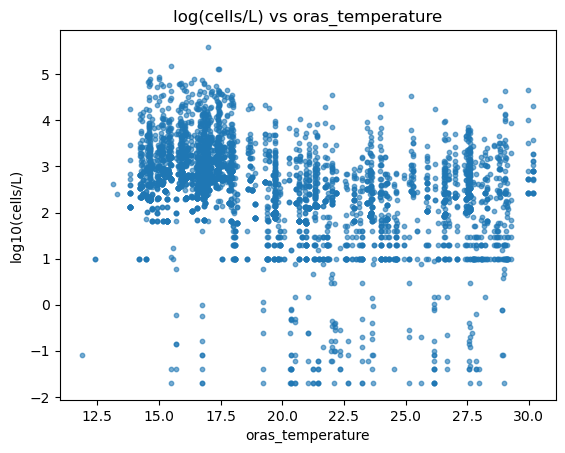

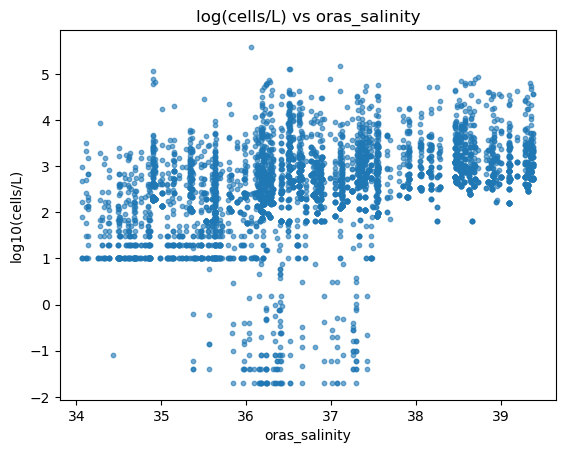

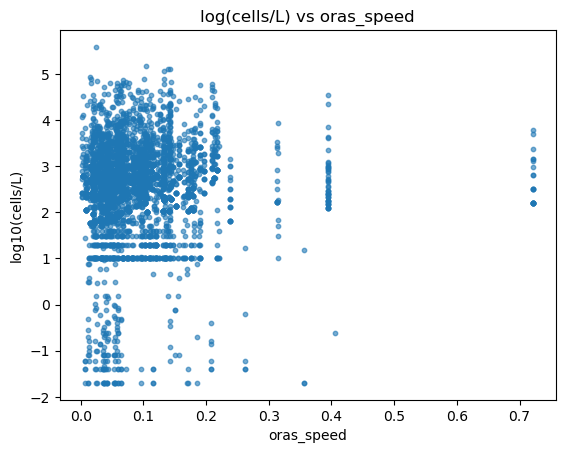

In [91]:
import matplotlib.pyplot as plt

vars_oras = ["oras_temperature", "oras_salinity", "oras_speed"]

for v in vars_oras:
    plt.figure()
    plt.scatter(df[v], df["log_cells"], s=10, alpha=0.6)
    plt.xlabel(v)
    plt.ylabel("log10(cells/L)")
    plt.title(f"log(cells/L) vs {v}")
    plt.show()

In [93]:
from scipy.stats import pearsonr, spearmanr

results = []

for v in vars_oras:
    x = df[v]
    y = df["log_cells"]
    
    mask = x.notna() & y.notna()
    r_p, p_p = pearsonr(x[mask], y[mask])
    r_s, p_s = spearmanr(x[mask], y[mask])
    
    results.append({
        "variable": v,
        "pearson_r": r_p,
        "pearson_p": p_p,
        "spearman_r": r_s,
        "spearman_p": p_s
    })

corr_df = pd.DataFrame(results)
corr_df

,variable,pearson_r,pearson_p,spearman_r,spearman_p
0,oras_temperature,-0.362064,1.462456e-137,-0.400219,2.119042e-170
1,oras_salinity,0.385283,5.086047e-157,0.474044,1.675202e-247
2,oras_speed,0.053778,3.380921e-04,0.090225,1.731327e-09


Step 3 — Linear correlations (Pearson + Spearman)

In this step, we tested whether biological abundance (CASCADE cells_per_L, transformed to log10(cells/L)) is associated with three environmental variables extracted from ORAS5: temperature, salinity, and current speed. We reported Pearson correlation (captures linear relationships) and Spearman correlation (captures monotonic relationships and is more robust to non-linear patterns and outliers). Because our sample size is large, even weak effects can become statistically significant, so we interpret the effect size (correlation magnitude) more than just the p-value.

Observed results:
	•	Temperature: Pearson r ≈ −0.36, Spearman r ≈ −0.40
This indicates a moderate negative association: as ORAS5 temperature increases, the average log abundance tends to decrease. The Spearman value being slightly stronger than Pearson suggests the relationship may not be perfectly linear (for example, there may be thresholds or curved responses).
	•	Salinity: Pearson r ≈ +0.39, Spearman r ≈ +0.47
This indicates a moderate-to-strong positive association: higher salinity is associated with higher abundance. Again, Spearman > Pearson suggests the relationship is likely non-linear or at least not strictly linear across the full salinity range.
	•	Speed: Pearson r ≈ +0.054, Spearman r ≈ +0.090
This indicates a very weak relationship. It is statistically significant due to the large number of samples, but the effect size is small. This is consistent with the idea that current speed is usually not a direct driver of growth, but can have secondary or context-dependent effects (transport, mixing, redistribution).

Key takeaway: Temperature and salinity show meaningful global associations with abundance, while speed shows only a minor association. These global correlations summarize patterns across many regions, depths, and species, so they represent an “average” effect that may hide stronger species-specific relationships.

In [97]:
!pip install pingouin

In [99]:
import pingouin as pg

partial_results = []

for v in vars_oras:
    tmp = df[[v, "log_cells", "depth"]].dropna()
    pc = pg.partial_corr(
        data=tmp,
        x=v,
        y="log_cells",
        covar="depth",
        method="spearman"
    )
    pc["variable"] = v
    partial_results.append(pc)

pd.concat(partial_results, ignore_index=True)

,n,r,CI95%,p-val,variable
0,4438,-0.428575,"[-0.45, -0.4]",1.001100e-197,oras_temperature
1,4438,0.473662,"[0.45, 0.5]",5.363357e-247,oras_salinity
2,4438,0.062709,"[0.03, 0.09]",2.914639e-05,oras_speed


Step 4 — Partial correlations controlling for depth

In this step, we computed partial Spearman correlations between abundance and each ORAS variable while controlling for depth. This is important because in the ocean many environmental variables (especially temperature) vary strongly with depth. Without controlling for depth, correlations can sometimes reflect vertical structure rather than true ecological coupling.

Observed results (n = 4438):
	•	Temperature (partial): r ≈ −0.43 (95% CI roughly −0.45 to −0.40)
	•	Salinity (partial): r ≈ +0.47 (95% CI roughly +0.45 to +0.50)
	•	Speed (partial): r ≈ +0.063 (95% CI roughly +0.03 to +0.09)

Interpretation:
	•	The temperature and salinity associations remain strong even after depth is accounted for. Temperature becomes slightly more negative than in Step 3, and salinity stays consistently positive. This is an important result because it suggests the relationships are not simply artifacts of “deep = cold” or “surface = warm”. Instead, temperature and salinity appear to reflect broader water-mass properties and ecological regimes that structure abundance beyond just vertical gradients.
	•	Speed remains weak, even after controlling for depth. This supports the interpretation that current speed has a secondary or contextual relationship with abundance and is not a dominant predictor at the global pooled level.

Role of the confidence interval (CI): The 95% CI ranges for temperature and salinity are narrow and far from zero, showing the effect estimates are stable and not driven by a small number of points. In contrast, speed has a small r with a CI close to zero, reinforcing that the effect exists but is minor.

Key takeaway: Temperature and salinity remain major structuring axes for abundance even after removing depth effects; speed remains weak.

/var/folders/qt/ytg6jkts3dn3qp0gd_3041b00000gn/T/ipykernel_72854/944311205.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return dfb.groupby("bin").agg(


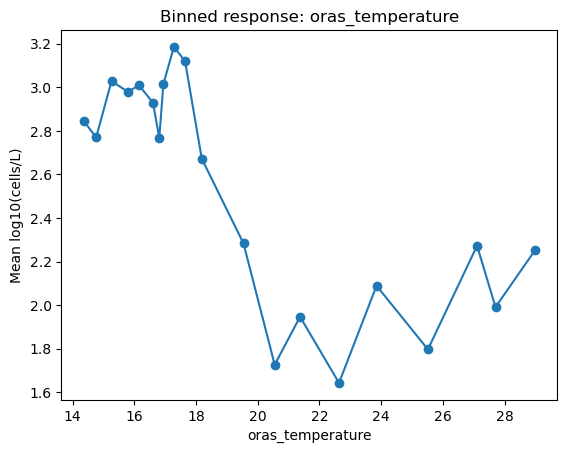

/var/folders/qt/ytg6jkts3dn3qp0gd_3041b00000gn/T/ipykernel_72854/944311205.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return dfb.groupby("bin").agg(


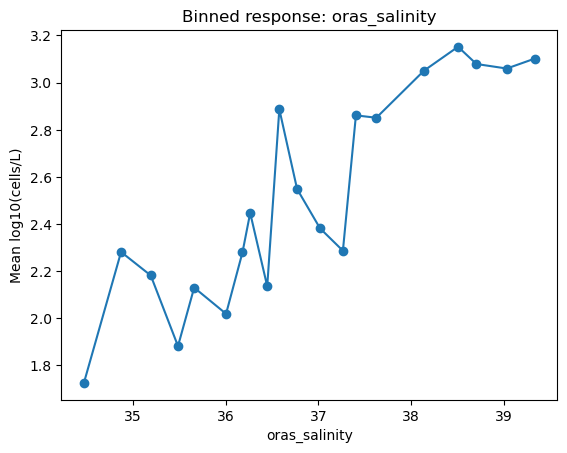

/var/folders/qt/ytg6jkts3dn3qp0gd_3041b00000gn/T/ipykernel_72854/944311205.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return dfb.groupby("bin").agg(


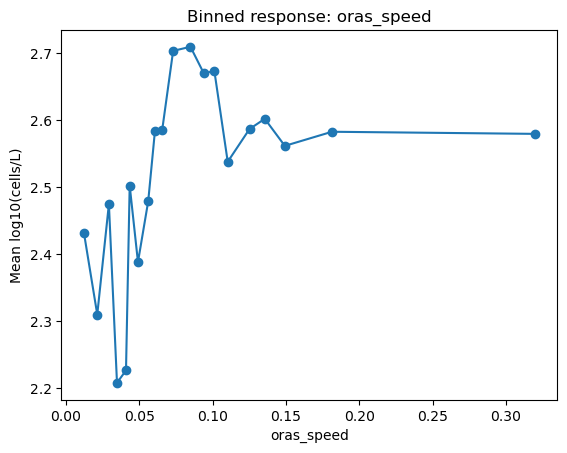

In [101]:
def binned_mean(x, y, bins=20):
    dfb = pd.DataFrame({"x": x, "y": y}).dropna()
    dfb["bin"] = pd.qcut(dfb["x"], bins, duplicates="drop")
    return dfb.groupby("bin").agg(
        x_mean=("x","mean"),
        y_mean=("y","mean"),
        n=("y","size")
    )

for v in vars_oras:
    b = binned_mean(df[v], df["log_cells"])
    plt.figure()
    plt.plot(b["x_mean"], b["y_mean"], marker="o")
    plt.xlabel(v)
    plt.ylabel("Mean log10(cells/L)")
    plt.title(f"Binned response: {v}")
    plt.show()

Step 5 — Non-linear patterns using binned response curves

Correlations summarize relationships with a single number, but biology often responds non-linearly to environmental gradients (e.g., thresholds, plateaus, optima). In this step, we visualized non-linear responses by dividing each ORAS variable into bins (quantiles) and plotting the mean log10(cells/L) in each bin. This reveals the shape of the response.

5A) Binned response for temperature

The temperature curve shows high mean abundance at cooler temperatures (around ~14–18°C), followed by a sharp decline around ~18–21°C and lower abundance in warmer bins. This indicates a threshold-like response rather than a smooth linear decline. A threshold can occur when crossing from relatively mixed/nutrient-rich regimes into more stratified/nutrient-limited conditions.

Interpretation: The negative correlations from Steps 3 and 4 are not just “linear cooling = more cells”, but likely reflect a regime boundary where abundance drops rapidly once temperature enters a less favorable range.

5B) Binned response for salinity

The salinity curve shows a strong, mostly monotonic rise: higher salinity bins correspond to higher mean abundance. This supports the interpretation that salinity is acting as a water-mass indicator. Higher salinity may represent stable open-ocean waters or particular water-mass types associated with higher productivity or species that prefer these conditions.

Interpretation: This binned curve explains why salinity had the strongest Spearman correlation: the relationship is monotonic and strong, but not necessarily perfectly linear.

5C) Binned response for current speed

The speed curve increases slightly from very low speeds up to moderate values (around ~0.07–0.1 in the plot), and then flattens into a plateau. This is a typical “saturation” pattern: extremely low flow might coincide with poor transport or reduced mixing, but beyond moderate speed, additional speed does not continuously increase biological abundance.

Interpretation: This explains why speed correlations were weak: speed does not scale abundance across its full range; it behaves more like a low-speed threshold plus saturation.

Key takeaway: Non-linear plots clarify that (i) temperature has a threshold/transition region, (ii) salinity shows a strong monotonic pattern, and (iii) speed shows a modest threshold + plateau rather than a strong trend.

In [103]:
from sklearn.feature_selection import mutual_info_regression

X = df[vars_oras].dropna()
y = df.loc[X.index, "log_cells"]

mi = mutual_info_regression(X, y, random_state=0)

pd.DataFrame({
    "variable": vars_oras,
    "mutual_information": mi
}).sort_values("mutual_information", ascending=False)

,variable,mutual_information
1,oras_salinity,2.236383
0,oras_temperature,2.220085
2,oras_speed,2.128472


In [105]:
top_species = df["species"].value_counts().head(3).index

for sp in top_species:
    sub = df[df["species"] == sp]
    print(f"\nSpecies: {sp} (n={len(sub)})")
    
    for v in vars_oras:
        r, p = spearmanr(sub[v], sub["log_cells"], nan_policy="omit")
        print(f"  {v}: Spearman r={r:.3f}, p={p:.3g}")


Species: Emiliania huxleyi HET (n=220)
  oras_temperature: Spearman r=-0.529, p=2.82e-17
  oras_salinity: Spearman r=0.523, p=7.1e-17
  oras_speed: Spearman r=0.186, p=0.00578

Species: Discosphaera tubifera HET (n=192)
  oras_temperature: Spearman r=-0.272, p=0.000137
  oras_salinity: Spearman r=0.309, p=1.34e-05
  oras_speed: Spearman r=0.158, p=0.0291

Species: Syracosphaera pulchra HET (n=180)
  oras_temperature: Spearman r=-0.659, p=7.93e-24
  oras_salinity: Spearman r=0.763, p=1.42e-35
  oras_speed: Spearman r=-0.091, p=0.224


Step 6 — Species-specific correlations (top species)

In this step, we repeated the Spearman correlation analysis separately for individual species (instead of pooling all species together). This matters because different species can occupy different ecological niches; pooling can hide strong relationships that are present within species.

6A) Emiliania huxleyi HET (n=220)
	•	Temperature: r ≈ −0.53 (strong negative)
	•	Salinity: r ≈ +0.52 (strong positive)
	•	Speed: r ≈ +0.19 (weak-to-moderate positive)

Interpretation: This species shows a clear niche pattern: it is more abundant in cooler, saltier waters, and there is also a small positive association with speed (possibly reflecting that moderate circulation/mixing helps maintain favorable conditions or transports populations). Compared to pooled results, the strength of temperature and salinity associations is noticeably higher, showing that species-level structure is stronger than the “global average”.

6B) Discosphaera tubifera HET (n=192)
	•	Temperature: r ≈ −0.27 (moderate negative)
	•	Salinity: r ≈ +0.31 (moderate positive)
	•	Speed: r ≈ +0.16 (weak positive)

Interpretation: This species shows the same direction of effects but with weaker magnitude, suggesting a broader tolerance or less specialization. It still appears more common in cooler, saltier conditions, but the niche constraint is less strict than for some other species.

6C) Syracosphaera pulchra HET (n=180)
	•	Temperature: r ≈ −0.66 (very strong negative)
	•	Salinity: r ≈ +0.76 (very strong positive)
	•	Speed: r ≈ −0.09 (not significant)

Interpretation: This species exhibits a very strong and consistent water-mass niche: abundance increases sharply with salinity and decreases strongly with temperature. Speed shows no meaningful relationship, reinforcing that speed is not universally relevant and may matter only for certain species or regions.

Key takeaway from Step 6: Species-specific relationships can be much stronger than pooled relationships. This supports the ecological interpretation that temperature and salinity are major niche axes, while current speed is secondary and can be species-dependent (important for some species, irrelevant for others).

⸻

Overall conclusion from Steps 3–6

Across the integrated CASCADE–ORAS5 dataset, temperature and salinity emerge as the strongest environmental correlates of biological abundance, and these relationships persist even after controlling for depth. The non-linear binned response curves show that the relationships are not purely linear: temperature exhibits a threshold-like transition, salinity shows a strong monotonic pattern, and speed shows a weak threshold/plateau behavior. Species-specific analyses reveal that ecological niches can be substantially stronger within individual taxa than in pooled data, which is why global correlations are moderate rather than extreme.

Practical interpretation: In this dataset, ORAS5 temperature and salinity provide meaningful water-mass context for CASCADE abundance patterns, while current speed provides weaker but sometimes species-specific context.